In [1]:
if "descended" not in locals():
    descended = 1
    %cd ".."
    
import utils

import os
import numpy as np
import matplotlib.pyplot as plt
import torch

from tqdm import tqdm
from detection import rnn_detection as rnn_det
from detection import bls_detection as bls_det
from simulations import lightcurve_simulation as lcsim
import visualize as vis

from scipy.ndimage import gaussian_filter1d

from wotan import flatten

/Users/Yke/Desktop/AI/Thesis/ESA/transit-detection-rnn


In [524]:
rnn = torch.load("models/bigru1_w4sqrt_sim.pt")
rnn_repr2 = torch.load("models/rnn_multi_2min.pt")
# rnn_repr4 = torch.load("models/bigru1repr4_sim.pt")

ModuleNotFoundError: No module named 'detectors'

### Monotransit example

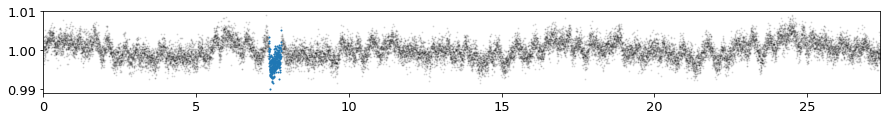

In [163]:
n_tr = 99
np.random.seed(29) # shows nice example with transit hidden in noise
while n_tr > 1:
    lc = lcsim.get_lightcurve(num_planets=1, min_transits=1, period_range=(2,100), t_max=27.4, 
                          max_attempts=4, max_snr_attempts=10, snr_range=(3,80), 
                          rdepth_range=(1,5.), dur_range=(0,utils.hour2day(14)))
    time, flux, pl_masks, params = lc
    n_tr = params["planets"][0]["pl_transits"]
pl1, pl2 = pl_masks[0], np.zeros_like(pl_masks[0])#pl_masks[1]
nontr = ~np.any(pl_masks, 0)

plt.figure(figsize=(15,1.5))
vis.plot(time[nontr], flux[nontr], c="black", a=0.1)
for msk in pl_masks:
    vis.plot(time[msk], flux[msk], c=plt.plot([])[0].get_color(), a=1)
plt.xlim(0,time[-1])
plt.show()

In [164]:
flux_ = (flux-1) / params["sigma"] 
flux_ = (flux_ - (-0.02693141794739591)) / 2.109453867034959

pts = rnn_det.get_pts(rnn, flux_.reshape(1,-1)).squeeze()
# pts2, repr2 = rnn_det.get_pts(rnn_repr2, flux_.reshape(1,-1), additional=True)
# pts4, repr4 = rnn_det.get_pts(rnn_repr4, flux_.reshape(1,-1), additional=True)

In [165]:
detected = rnn_det.get_peaks(gaussian_filter1d(pts,11)>0.5) 

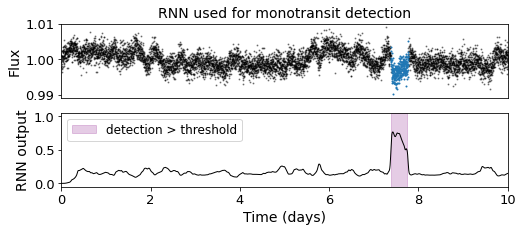

In [166]:
plt.figure(figsize=(8,3))
plt.subplot(2,1,1)
plt.title("RNN used for monotransit detection", fontsize=14)
vis.plot(time[nontr], flux[nontr], c="black", a=.4)
for msk in pl_masks:
    vis.plot(time[msk], flux[msk], c=plt.plot([])[0].get_color(), a=1)
plt.xticks([]), plt.yticks(fontsize=13)
plt.ylabel("Flux", fontsize=14)
plt.xlim(0,10)

plt.subplot(2,1,2)
vis.plot(time, gaussian_filter1d(pts,9), scatter=0)
for det in detected:
    plt.axvspan(time[det][0], time[det][-1], color="purple", alpha=0.2, label="detection > threshold")
plt.ylim(-0.05,1.05)
plt.ylabel("RNN output", fontsize=14)
plt.xlabel("Time (days)", fontsize=14)
plt.xticks(fontsize=13), plt.yticks(fontsize=13)
plt.xlim(0,10)
plt.legend(fontsize=12)

plt.show()

### Period search

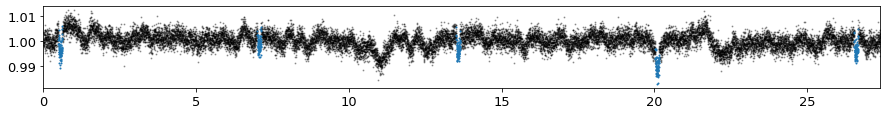

In [129]:
n_tr = 99
np.random.seed(42)
while n_tr > 5 or n_tr < 3:
    lc = lcsim.get_lightcurve(num_planets=1, min_transits=1, period_range=(2,100), t_max=27.4, 
                          max_attempts=4, max_snr_attempts=10, snr_range=(3,80), 
                          rdepth_range=(1,5.), dur_range=(0,utils.hour2day(14)))
    time, flux, pl_masks, params = lc
    n_tr = params["planets"][0]["pl_transits"]
pl1, pl2 = pl_masks[0], np.zeros_like(pl_masks[0])#pl_masks[1]
nontr = ~np.any(pl_masks, 0)

plt.figure(figsize=(15,1.5))
vis.plot(time[nontr], flux[nontr], c="black", a=0.3)
for msk in pl_masks:
    vis.plot(time[msk], flux[msk], c=plt.plot([])[0].get_color(), a=1)
plt.xlim(0,time[-1])
plt.show()

In [130]:
flux_ = (flux-1) / params["sigma"] 
flux_ = (flux_ - (-0.02693141794739591)) / 2.109453867034959

pts = rnn_det.get_pts(rnn, flux_.reshape(1,-1)).squeeze()
# pts2, repr2 = rnn_det.get_pts(rnn_repr2, flux_.reshape(1,-1), additional=True)
# pts4, repr4 = rnn_det.get_pts(rnn_repr4, flux_.reshape(1,-1), additional=True)

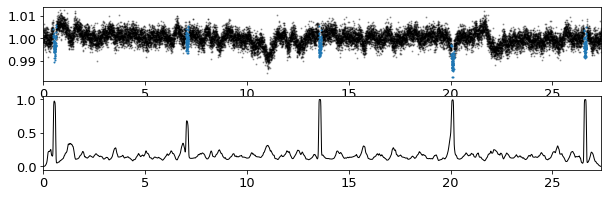

In [80]:
plt.figure(figsize=(10,3))
plt.subplot(2,1,1)
vis.plot(time[nontr], flux[nontr], c="black", a=0.3)
for msk in pl_masks:
    vis.plot(time[msk], flux[msk], c=plt.plot([])[0].get_color(), a=1)
plt.xlim(0,time[-1])

plt.subplot(2,1,2)
vis.plot(time, gaussian_filter1d(pts, 9), scatter=0)
plt.xlim(0,time[-1])
plt.ylim(-0.05, 1.05)
gaussian_filter1d
plt.show()

In [10]:
# flat = flatten(time, flux, method="median", window_length=0.5)
# bls_det.algorithm(time, flat, show_steps=1, num_iters=2)

In [219]:
def get_pfold_figure(time, flux, mask, steps, ylims=(None,None), true_per=None, ylims2=(0.2,2.5)):
    lbls = ["a", "b", "c", "d"]
    h = len(steps["pts"])
    plt.figure(figsize=(13,1.5*h+2))
    plt.subplot(h+1,2,1)
    vis.plot(time[~mask], flux[~mask], c="black", a=0.15, s=1, z=-1)
    vis.plot(time[mask], flux[mask], c="orange", a=1, z=100)
    plt.xlim(0,time[-1]), plt.ylim(*ylims)
    plt.xticks([]), plt.yticks(fontsize=13)
    plt.ylabel("Flux", fontsize=14), plt.title("Input light curve", fontsize=14)
    
    for i in range(len(steps["pts"])):
        ax =plt.subplot(h+1,2,3+i*2)
        vis.plot(time, steps["pts"][i].squeeze(), scatter=0, s=1.1)
        plt.xlim(0,time[-1]), plt.ylim(-0.05,1.05)
        plt.xticks([]) if i!= len(steps["pts"])-1 else plt.xticks(fontsize=13)
        plt.xlabel("Time (days)", fontsize=14) if i==len(steps["pts"])-1 else None
        plt.ylabel("RNN \noutput", fontsize=14) if i==0 else plt.ylabel("RNN \noutput*", fontsize=14)
        plt.yticks(fontsize=13)
        plt.text(.1,0.9,f"({lbls[i*2]})", fontsize=13, ha='right', va='top', transform=ax.transAxes)
        
        ax = plt.subplot(h+1,2,3+i*2+1)
        plt.title("Spectrum used for detection", fontsize=14) if i==0 else None
        vis.plot(steps1["periods"], steps["scores"][i].squeeze(), scatter=0, s=1.1)
        argmax = np.argmax(steps["scores"][i].squeeze())
        if i == 0:
            if true_per is not None:
                plt.plot([], linewidth=1.5, color="green", label="True", alpha=1)
                plt.axvline(true_per, color="green", linestyle="-", alpha=1, zorder=-2, linewidth=1.5)
                
            plt.axvline(steps1["periods"][argmax], color="red", linewidth=1.5, linestyle="--", alpha=1, zorder=-1)
            plt.plot([], linewidth=1.5, color="red", linestyle="--",  label="Prediction", alpha=1)
            plt.legend(ncol=2, fontsize=11.5, loc="upper right", framealpha=1)
        plt.ylim(*ylims2)
        plt.xticks([]) if i!= len(steps["pts"])-1 else plt.xticks(fontsize=13)
        plt.xlabel("Period (days)", fontsize=14) if i==len(steps["pts"])-1 else None
        plt.ylabel("Candidate \nscore", fontsize=14)
        plt.yticks(fontsize=13)
        plt.text(.1,0.9,f"({lbls[i*2+1]})", fontsize=13, ha='right', va='top', transform=ax.transAxes)
    plt.show()    
    
def get_ppeak_figure(time, flux, masks, steps, ylims=(None,None), nontr=None):
    nontr = ~masks if nontr is None else nontr
    lbls = ["a", "a", "b", "b"]
    plcolors = [plt.plot([])[0].get_color() for i in range(len(masks)) if isinstance(masks, list)]
    plt.close()
    h = len(steps["pts"])
    plt.figure(figsize=(13,1.5*h+2))
    plt.subplot(h+1,2,1)
    vis.plot(time[nontr], flux[nontr], c="black", a=0.15, s=1, z=-1)
    
    if isinstance(masks, list):
        for i, mask in enumerate(masks):
            vis.plot(time[mask], flux[mask], c=plcolors[i], a=1, z=100)
    else:
        mask = masks
        vis.plot(time[mask], flux[mask], c="orange", a=1, z=100)
    plt.xlim(0,time[-1]), plt.ylim(*ylims)
    plt.xticks([]), plt.yticks(fontsize=13)
    plt.ylabel("Flux", fontsize=14)
    plt.title("Input light curve", fontsize=14)
    
    for i in range(len(steps["pts"])):
        ax = plt.subplot(h+1,2,3+i)
        vis.plot(time, steps["pts"][i].squeeze(), scatter=0, s=1.1)        
        c = (-1) if i == 0 else c
        for ci, peak in enumerate(steps["peaks"]):
            if i==0 or (i!=0 and ci not in c):
                plt.axvspan(time[peak[0]], time[peak[-1]], alpha=0.15, color="purple")
        c = steps["best_candidates"][i]
        plt.xlim(0,time[-1]), plt.ylim(-0.05,1.05)
    #     plt.xticks([]) if i!= len(steps2["pts"])-1 else plt.xticks(fontsize=13)
        plt.xticks(fontsize=13)
        plt.xlabel("Time (days)", fontsize=14) #if i==len(steps2["pts"])-1 else None
        plt.ylabel("RNN output", fontsize=14) if i==0 else plt.ylabel("RNN output*", fontsize=14)
        plt.yticks(fontsize=13)
        plt.text(.1,0.9,f"({lbls[i*2]})", fontsize=13, ha='right', va='top', transform=ax.transAxes)
    plt.show()

In [132]:
det1, steps1 = rnn_det.algorithm1(pts, num_iters=2, smooth=True, show_steps=0, return_steps=1)
steps1.keys()

dict_keys(['pts', 'scores', 't0', 'masks', 'periods'])

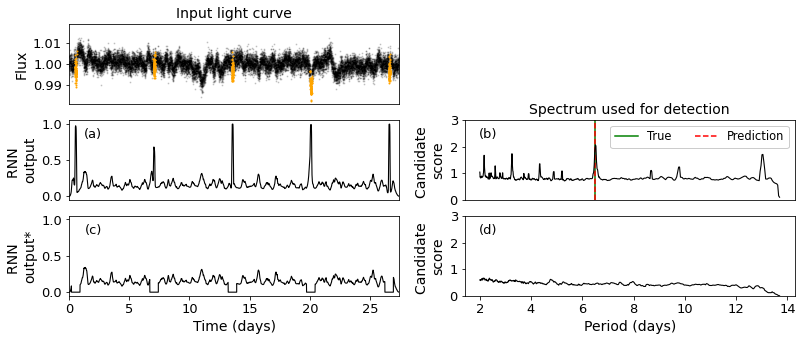

In [133]:
true_period = params["planets"][0]["pl_period"]
get_pfold_figure(time, flux, pl1, steps1, ylims=(None,1.019), true_per=true_period, ylims2=(0,3))

In [36]:
det2, steps2 = rnn_det.algorithm2(pts, [], num_iters=2, smooth=True, return_steps=1)
print(steps2.keys())
for i in steps2["info"]:
    print(i)

dict_keys(['peaks', 'candidates', 'pts', 'info', 'masks', 'best_candidates'])
(1, 5, 7, 10, 12) new best: score = 2.066841034407201, period = 6.5166666666666675 d
(1, 5, 7, 10, 12) harmonics evaluated: tried 2 harmonics, new score = 2.066841034407201, period = 6.5166666666666675 d
(0, 8) new best: score = 0.39220811982394915, period = 15.372222222222224 d
(0, 11) new best: score = 0.3923714388619288, period = 24.893055555555556 d
(2, 8) new best: score = 0.45614389856403537, period = 14.402777777777779 d
(2, 10) new best: score = 0.500539639691198, period = 18.73888888888889 d
(2, 10) harmonics evaluated: tried 8 harmonics, new score = 0.8151979198878831, period = 2.6769841269841272 d


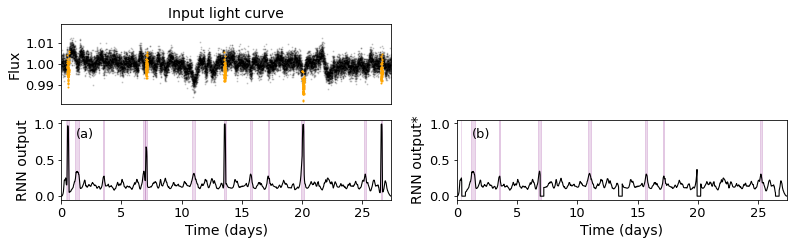

In [33]:
get_ppeak_figure(time, flux, pl1, steps2, ylims=(None,1.019))

In [16]:
[params["planets"][i]["pl_period"] for i in params["planets"]], det1, det2

([6.512839540648651],
 {2.0625132183417594: {'period': 6.511111111111111,
   't0': 0.5430555555555556,
   'duration': 0.35555555555555607},
  0.6658419237759813: {'period': 2.1333333333333333,
   't0': 1.4041666666666668,
   'duration': 0.29999999999999893}},
 {2.066841034407201: {'period': 6.5166666666666675,
   't0': 0.5444444444444443,
   'duration': 0.15138888888888857},
  0.8151979198878831: {'period': 2.6769841269841272,
   't0': 1.3305555555555557,
   'duration': 0.3097222222222219}})

### Successes and failures

In [134]:
def correct_detection(det, gt):
    
    true_p = gt["pl_period"]
    true_dur = gt["pl_duration"]
    true_t0 = gt["pl_t0"]
    
    t0_correct = (det["t0"] >= true_t0-0.5*true_dur) and (det["t0"] <= true_t0+0.5*true_dur)
    per_correct = (0.99*true_p <= det["period"]) and (det["period"] <= 1.01*true_p)
    
    return (t0_correct and per_correct), t0_correct, per_correct

In [135]:
def explore_examples(iters, rn_seed=None):
    rn_seed = 0 if rn_seed is None else rn_seed
    seeds = []
    results1 = {"correct":[], "t0_correct":[], "per_correct":[]}
    results2 = {"correct":[], "t0_correct":[], "per_correct":[]}
    pbar = tqdm(range(iters))
    for i in pbar:
        try:  
            n_tr = 99
            while n_tr > 5 or n_tr < 3:
                np.random.seed(rn_seed)
                lc = lcsim.get_lightcurve(num_planets=1, min_transits=1, period_range=(2,100), t_max=27.4, 
                                      max_attempts=4, max_snr_attempts=10, snr_range=(3,80), 
                                      rdepth_range=(1,5.), dur_range=(0,utils.hour2day(14)))
                time, flux, pl_masks, params = lc
                n_tr = params["planets"][0]["pl_transits"]
                rn_seed += 1
            seeds.append(rn_seed-1)
            pl1, pl2 = pl_masks[0], np.zeros_like(pl_masks[0])
            nontr = ~np.any(pl_masks, 0)
            flux_ = (flux-1) / params["sigma"] 
            flux_ = (flux_ - (-0.02693141794739591)) / 2.109453867034959
            pts = rnn_det.get_pts(rnn, flux_.reshape(1,-1)).squeeze()
            det1_, steps1_ = rnn_det.algorithm1(pts, num_iters=2, smooth=True, show_steps=0, return_steps=1)
            det2_, steps2_ = rnn_det.algorithm2(pts, [], num_iters=2, smooth=True, return_steps=1)

            for scr, dt in det1_.items():
                if scr == np.max(list(det1_.keys())):
                    res = correct_detection(dt, params["planets"][0])
                    results1["correct"].append(res[0])
                    results1["t0_correct"].append(res[1])
                    results1["per_correct"].append(res[2])
                    break
            for scr, dt in det2_.items():
                if scr == np.max(list(det2_.keys())):
                    res = correct_detection(dt, params["planets"][0])
                    results2["correct"].append(res[0])
                    results2["t0_correct"].append(res[1])
                    results2["per_correct"].append(res[2])
                    break
            rn_seed += 1
        except:
            pbar.close()
            raise
    seeds = np.array(seeds)
    for r in results1:
        results1[r] = np.array(results1[r])
        results2[r] = np.array(results2[r])
    return seeds, results1, results2

In [68]:
def get_example(fold_goal, peak_goal, num_iters=2, rn_seed=None):
    rn_seed = 0 if rn_seed is None else rn_seed  
    pfold_success, ppeak_success = -1,-1
    while not (pfold_success==fold_goal and ppeak_success==peak_goal):
        n_tr = 99
        while n_tr > 5 or n_tr < 3:
            print(rn_seed)
            np.random.seed(rn_seed)
            lc = lcsim.get_lightcurve(num_planets=1, min_transits=1, period_range=(2,100), t_max=27.4, 
                                  max_attempts=4, max_snr_attempts=10, snr_range=(3,80), 
                                  rdepth_range=(1,5.), dur_range=(0,utils.hour2day(14)))
            time, flux, pl_masks, params = lc
            n_tr = params["planets"][0]["pl_transits"]
            rn_seed += 1
        pl1, pl2 = pl_masks[0], np.zeros_like(pl_masks[0])
        nontr = ~np.any(pl_masks, 0)
        flux_ = (flux-1) / params["sigma"] 
        flux_ = (flux_ - (-0.02693141794739591)) / 2.109453867034959
        pts = rnn_det.get_pts(rnn, flux_.reshape(1,-1)).squeeze()
        det1_, steps1_ = rnn_det.algorithm1(pts, num_iters=2, smooth=True, show_steps=0, return_steps=1)
        det2_, steps2_ = rnn_det.algorithm2(pts, [], num_iters=2, smooth=True, return_steps=1)

        for scr, dt in det1_.items():
            if scr == np.max(list(det1_.keys())):
                correct1, correct1_t0, correct1_per = correct_detection(dt, params["planets"][0])
                break
        for scr, dt in det2_.items():
            if scr == np.max(list(det2_.keys())):
                correct2, correct2_t0, correct2_per = correct_detection(dt, params["planets"][0])
                break
        pfold_success, ppeak_success = correct1, correct2
        rn_seed += 1
    result = {"rn_seed":rn_seed-2, "det1":det1_, "det2":det2_, "steps1":steps1_, "steps2":steps2_,
             "correct1":{"period":correct1_per, "t0":correct1_t0},
             "correct2":{"period":correct2_per, "t0":correct2_t0},
             "time":time, "flux":flux, "pts":pts, "mask":pl1, "params":params}
    return result

In [20]:
# examples = explore_examples(250)

100%|██████████| 250/250 [11:04<00:00,  2.66s/it]


In [49]:
# seeds, results1, results2 = examples

In [50]:
# len(seeds), len(results1["correct"]), len(results2["correct"])

(250, 250, 250)

In [51]:
# fold_not_peak = seeds[np.where(results1["correct"] & (~results2["correct"]))[0]]-1
# peak_not_fold = seeds[np.where(results2["correct"] & (~results1["correct"]))[0]]-1
# not_fold_not_peak = not_peak_not_fold = seeds[np.where((~results1["correct"]) & (~results2["correct"]))[0]]-1

In [136]:
fold_not_peak = np.array([  56,   73,   91,  105,  283,  297,  358,  431,  815, 1145, 1182, 1294])
peak_not_fold = np.array([1174])
not_fold_not_peak = np.array([   2,   40,   43,   76,  129,  152,  156,  159,  221,  235,  248,
                               264,  300,  383,  385,  390,  407,  436,  448,  460,  465,  468,
                               476,  478,  490,  553,  584,  586,  605,  645,  669,  690,  748,
                               775,  790,  792,  797,  836,  898,  908,  912,  932,  942,  972,
                               977,  985,  998, 1127, 1129, 1131, 1216, 1241, 1263, 1269, 1272,
                              1284, 1313, 1318, 1324, 1333, 1338, 1366])

Where PTS-Peak fails and PTS-Fold succeeds

In [151]:
# 73 is good, or 431
example1 = get_example(fold_goal=1, peak_goal=0, num_iters=2, rn_seed=431)
time, flux, mask = example1["time"], example1["flux"], example1["mask"]
steps1, steps2 = example1["steps1"], example1["steps2"]
true_period = example1["params"]["planets"][0]["pl_period"]

431


fold not peak


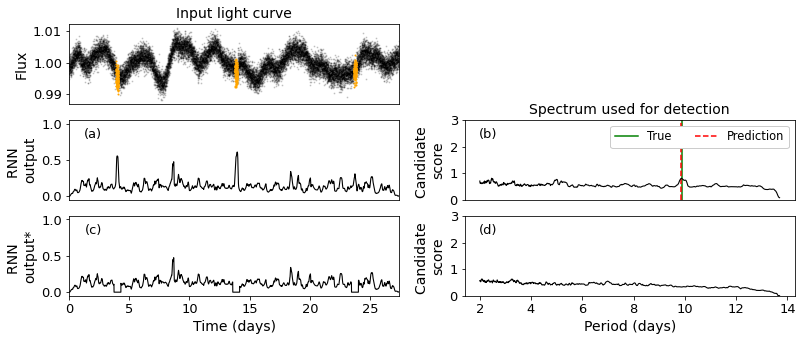

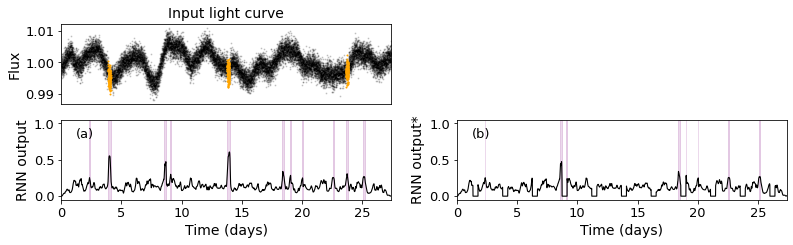

In [152]:
print("fold not peak")
get_pfold_figure(time, flux, mask, steps1, ylims=(None,None), true_per=true_period, ylims2=(0,3))
get_ppeak_figure(time, flux, mask, steps2, ylims=(None,None))

Where PTS-Peak succeeds and PTS-Fold fails

In [149]:
# 73 is good
example2 = get_example(fold_goal=0, peak_goal=1, num_iters=2, rn_seed=1174)
time, flux, mask = example2["time"], example2["flux"], example2["mask"]
steps1, steps2 = example2["steps1"], example2["steps2"]
true_period = example2["params"]["planets"][0]["pl_period"]

1174


peak, not fold (t0 fail)


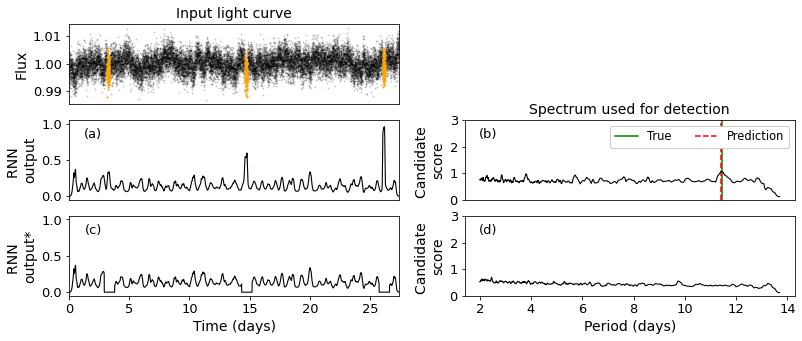

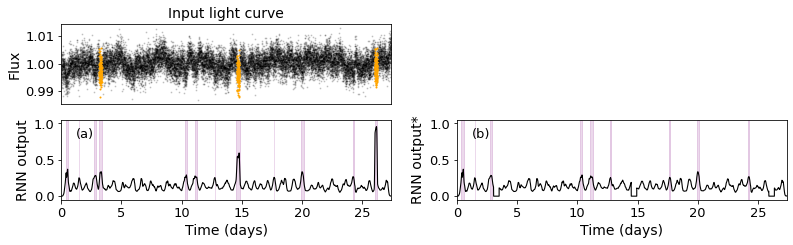

In [150]:
print("peak, not fold (t0 fail)")
get_pfold_figure(time, flux, mask, steps1, ylims=(None,None), true_per=true_period, ylims2=(0,3))
get_ppeak_figure(time, flux, mask, steps2, ylims=(None,None))

In [143]:
example2['correct1'][]

{'period': True, 't0': False}

Where both PTS-Peak and PTS-Fold fail

In [154]:
# 605 is good (lara)
example3 = get_example(fold_goal=0, peak_goal=0, num_iters=2, rn_seed=605)
time, flux, mask = example3["time"], example3["flux"], example3["mask"]
steps1, steps2 = example3["steps1"], example3["steps2"]
true_period = example3["params"]["planets"][0]["pl_period"]

605


both not


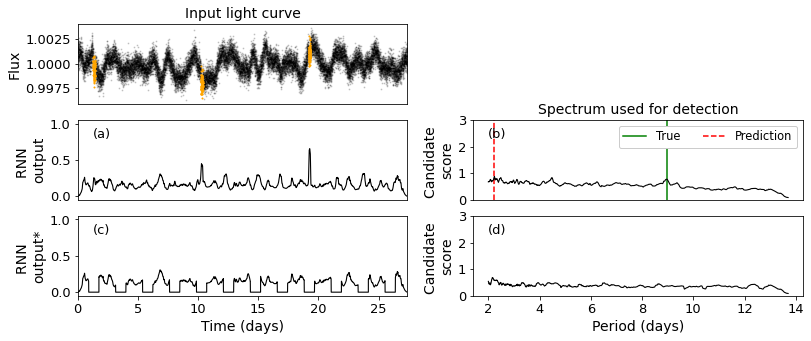

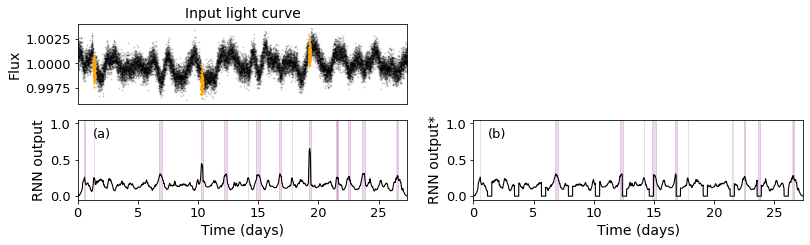

In [155]:
print("both not")
get_pfold_figure(time, flux, mask, steps1, ylims=(None,None), true_per=true_period, ylims2=(0,3))
get_ppeak_figure(time, flux, mask, steps2, ylims=(None,None))

### PTS-peak ambiguity

In [423]:
i

144

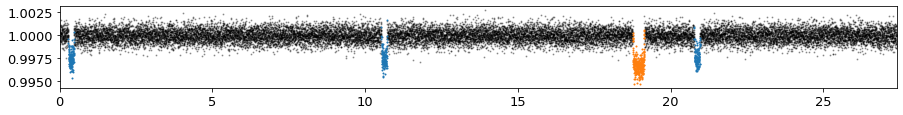

In [578]:
st_params = lcsim.get_stellar_params(rot_sigma=1e-15, rot_period=30, gran_period=30, gran_sigma=1e-15)
# st_params=None
i += 1
# i = 144
np.random.seed(i)
lc = lcsim.get_lightcurve(num_planets=2, min_transits=1, period_range=(2,100), t_max=27.4, 
                      max_attempts=4, max_snr_attempts=10, snr_range=(3,80), sigma=0.0007,
                      rdepth_range=(3,5.), dur_range=(0,utils.hour2day(14)), st_params=st_params)
ntr1 = params["planets"][0]["n_transit"]
time, flux, pl_masks, params = lc
pl1, pl2 = pl_masks[0], pl_masks[1]
nontr = ~np.any(pl_masks, 0)

plt.figure(figsize=(15,1.5))
vis.plot(time[nontr], flux[nontr], c="black", a=0.3)
for msk in pl_masks:
    vis.plot(time[msk], flux[msk], c=plt.plot([])[0].get_color(), a=1)
plt.xlim(0,time[-1])
plt.show()

In [579]:
rnn_repr2 = torch.load("models/bigru1repr2_sim.pt")

In [585]:
flux_ = (flux-1) / params["sigma"]
flux_ = (flux_ - (-0.02693141794739591))/3.1573894104562314
# pts = rnn_det.get_pts(rnn, flux_.reshape(1,-1)).squeeze()
pts2, repr2 = rnn_det.get_pts(rnn_repr2, flux_.reshape(1,-1), additional=True)
# pts4, repr2 = rnn_det.get_pts(rnn_repr4, flux_.reshape(1,-1), additional=True)
# repr2 = repr4

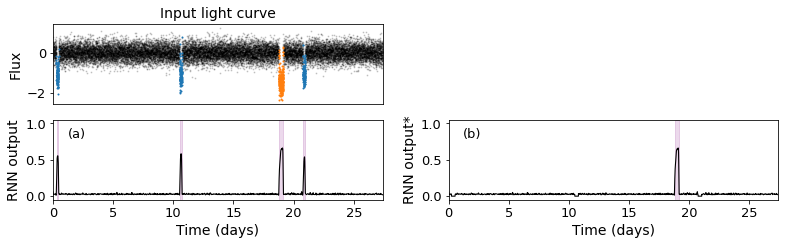

In [586]:
det2, steps2 = rnn_det.algorithm2(pts2, [], num_iters=2, smooth=True, return_steps=1)
get_ppeak_figure(time, flux_, [pl1,pl2], steps2, ylims=(None,None), nontr=nontr)

In [587]:
repr2 /= np.linalg.norm(repr2, axis=1)[:,None]

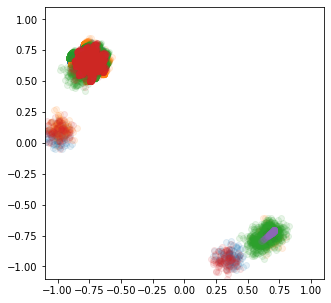

In [588]:
plt.figure(figsize=(5,5))
for peak in steps2["peaks"]:
    e1 = np.random.normal(0,.05,len(repr2[peak]))[:,None]
    e2 = np.random.normal(0,.05,len(repr2[peak]))[:,None]
#     e1 = np.zeros(len(repr2[peak]))[:,None]
#     e2 = np.zeros(len(repr2[peak]))[:,None]

    plt.scatter(repr2[peak][:,0] + e1, repr2[peak][:,1] + e2, alpha=0.1)
#     plt.scatter((repr2[peak]+e1)[nontr[peak]][:,0], (repr2[peak]+e2)[nontr[peak]][:,1], alpha=.2, s=1, c="gray")

#     plt.scatter((repr2[peak]+e1)[pl1[peak]][:,0], (repr2[peak]+e2)[pl1[peak]][:,1], alpha=.5)
#     plt.scatter((repr2[peak]+e1)[pl2[peak]][:,0], (repr2[peak]+e2)[pl2[peak]][:,1], alpha=.5)
plt.scatter(repr2[nontr][:,0], repr2[nontr][:,1], alpha=0.1)
plt.xlim(-1.1,1.1)
plt.ylim(-1.1,1.1)
plt.show()

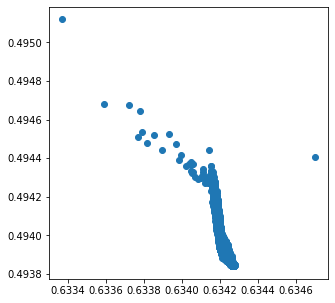

In [504]:
plt.figure(figsize=(5,5))
plt.scatter(repr2[:,0], repr2[:,1])

In [434]:
repr2.shape

(19728, 2)